# HW3 Image Classification
## We strongly recommend that you run with [Kaggle](https://www.kaggle.com/t/86ca241732c04da99aca6490080bae73) for this homework

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2023-spring@googlegroups.com

# Import Packages

In [19]:
_exp_name = "sample"

In [20]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# This is for the progress bar.
from tqdm.auto import tqdm
import random

In [21]:
myseed = 42  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Transforms
Torchvision provides lots of useful utilities for image preprocessing, data *wrapping* as well as data augmentation.

Please refer to PyTorch official website for details about different transforms.

In [22]:
test_tfm = transforms.Compose([
    transforms.RandomResizedCrop((256, 256)),
    
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

train_tfm = transforms.Compose([
    transforms.RandomResizedCrop((256, 256)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])


# Datasets
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [23]:
class FoodDataset(Dataset):

    def __init__(self,path,tfm=train_tfm,files = None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
            
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
            
        return im,label

# Model

In [28]:
import torchvision
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
#         self.cnn = nn.Sequential(
#             nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

#             nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

#             nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

#             nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
#             nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
#         )
#         self.fc = nn.Sequential(
#             nn.Linear(512*4*4, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Linear(512, 11)
#         )
        self.res = torchvision.models.resnext50_32x4d(weights= None)
#         self.res.fc = nn.Linear(self.res.fc.in_features, 11)
    def forward(self, x):
#         out = self.cnn(x)
#         out = out.view(out.size()[0], -1)
#         return self.fc(out)
        return self.res(x)

# Configurations

In [29]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)

# The number of batch size.
batch_size = 64

# The number of training epochs.
n_epochs = 300

# If no improvement in 'patience' epochs, early stop.
patience = 100

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, 
                mode='min', 
                factor=0.1, 
                patience=50,
                eps = 1e-5,
                verbose=True
            )

# Dataloader

In [30]:
# Construct train and valid datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset("./train", tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset("./valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Start Training

In [31]:
# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    scheduler.step(valid_loss)
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    
    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a") as f:
            f.write(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best\n")
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

  0%|          | 0/157 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Dataloader for test

In [32]:
# Construct test datasets.
# The argument "loader" tells how torchvision reads the data.
test_set = FoodDataset("./test", tfm=train_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# Testing and generate prediction CSV

In [33]:
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(f"901.ckpt"))
model_best.eval()
model2 = Classifier().to(device)
model2.load_state_dict(torch.load(f"897.ckpt"))
model2.eval()
prediction = []
with torch.no_grad():
    for idx in tqdm(range(len(test_set))):
        test_pred = model_best(test_set[idx][0].unsqueeze(0).to(device))[:,:11]
        for _ in range(3):
            test_pred += model(test_set[idx][0].unsqueeze(0).to(device))[:,:11]
            test_pred += model2(test_set[idx][0].unsqueeze(0).to(device))[:,:11]
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.tolist()

  0%|          | 0/3000 [00:00<?, ?it/s]

In [24]:
# create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(len(test_set))]
df["Category"] = prediction
df.to_csv("submission.csv",index = False)

# Q1. Augmentation Implementation
## Implement augmentation by finishing train_tfm in the code with image size of your choice. 
## Directly copy the following block and paste it on GradeScope after you finish the code
### Your train_tfm must be capable of producing 5+ different results when given an identical image multiple times.
### Your  train_tfm in the report can be different from train_tfm in your training code.


In [13]:
# train_tfm = transforms.Compose([
#     transforms.RandomResizedCrop((256, 256)),
#     transforms.RandomRotation(30),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
# ])

# Q2. Visual Representations Implementation
## Visualize the learned visual representations of the CNN model on the validation set by implementing t-SNE (t-distributed Stochastic Neighbor Embedding) on the output of both top & mid layers (You need to submit 2 images). 


In [9]:
# import torch
# import numpy as np
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# from tqdm.auto import tqdm
# import matplotlib.cm as cm
# import torch.nn as nn

# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# # Load the trained model
# model = Classifier().to(device)
# state_dict = torch.load(f"sample_best.ckpt")
# model.load_state_dict(state_dict)
# model.eval()

# print(model)

Classifier(
  (res): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

In [10]:
# buffer = []
# def get_activation(name):
#     def hook(model, input, output):
#         buffer.append(output.detach().cpu())
#     return hook
# model.res.layer2.register_forward_hook(get_activation('layer2'))

  0%|          | 0/57 [00:00<?, ?it/s]

/home/wendell/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/wendell/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


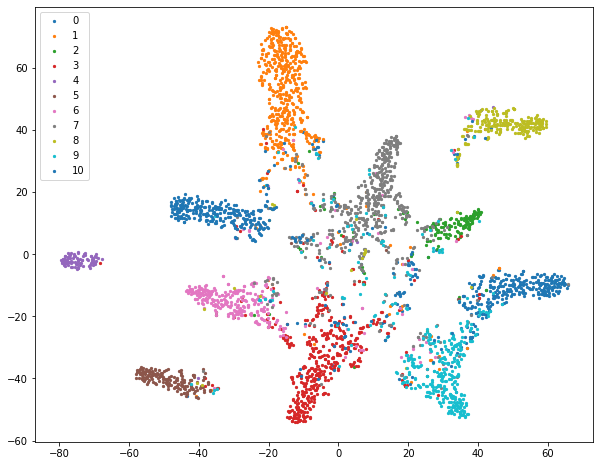

In [18]:
# # # Load the vaildation set defined by TA
# # valid_set = FoodDataset("./valid", tfm=test_tfm)
# # valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# # # Extract the representations for the specific layer of model
# # index = -1 # You should find out the index of layer which is defined as "top" or 'mid' layer of your model.
# features = []
# labels = []
# for batch in tqdm(valid_loader):
#     imgs, lbls = batch
#     with torch.no_grad():
#         logits = model(imgs.to(device))
#         logits = logits.view(logits.size()[0], -1)
#     labels.extend(lbls.cpu().numpy())
#     logits = np.squeeze(logits.cpu().numpy())
#     features.extend(logits)
    
# features = np.array(features)
# # features = torch.cat(buffer,dim = 0)
# # features = np.array(features.view(features.size()[0], -1))
# # print(features.shape)
# colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# # # Apply t-SNE to the features
# features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# # # Plot the t-SNE visualization
# plt.figure(figsize=(10, 8))
# for label in np.unique(labels):
#     plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
# # plt.xlim(-25,0)
# # plt.ylim(-25,0)
# plt.legend()
# plt.savefig(f"top.png")
# plt.show()